In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from sklearn.covariance import EllipticEnvelope

from numba import jit
from functools import partial

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

Duplicate key in file WindowsPath('d:/source/Anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  Microsoft JhengHei')


In [2]:
for i in ["08","09","10","11"]:
    exec(f"TXF{i}_df = pd.read_parquet(f'datas/SJ_下載{i}月的TXF逐筆成交明細.pqt')")
    exec(f"ZEF{i}_df = pd.read_parquet(f'datas/SJ_下載{i}月的ZEF逐筆成交明細.pqt')")
    exec(f"TXF{i}_df.ts = pd.to_datetime(TXF{i}_df.ts)")
    exec(f"ZEF{i}_df.ts = pd.to_datetime(ZEF{i}_df.ts)")
    exec(f"TXF{i}_df = TXF{i}_df.set_index('ts')")
    exec(f"ZEF{i}_df = ZEF{i}_df.set_index('ts')")
    exec(f"TXF{i}_df = TXF{i}_df.groupby(TXF{i}_df.index).mean()")
    exec(f"ZEF{i}_df = ZEF{i}_df.groupby(ZEF{i}_df.index).mean()")
    exec(f"TXF{i}_df_sec = TXF{i}_df.resample('1s').ffill().dropna().reset_index()")
    exec(f"ZEF{i}_df_sec = ZEF{i}_df.resample('1s').ffill().dropna().reset_index()")
    exec(f"TXF{i}_df_sec_close = TXF{i}_df_sec[[\"ts\", \"close\", \"bid_price\", \"ask_price\"]]")
    exec(f"ZEF{i}_df_sec_close = ZEF{i}_df_sec[[\"ts\", \"close\", \"bid_price\", \"ask_price\"]]")


# TXF10_df = pd.read_parquet("datas/SJ_下載10月的TXF逐筆成交明細.pqt")
# ZEF10_df = pd.read_parquet("datas/SJ_下載10月的ZEF逐筆成交明細.pqt")

##### 觀察特定檔案

In [53]:
ZEF11_df_sec_close.to_csv("datas/觀察ZEF11_df_sec_close.csv")

##### 排除8/5大跌期間

In [76]:
def exclude_time_range(df, start_time, end_time):
    """
    排除指定日期時間範圍內的數據並重置索引。

    參數:
    df : DataFrame - 包含時間戳欄位的資料框
    start_time : str or datetime - 要排除的開始時間 (包含)，格式如 "YYYY-MM-DD HH:MM"
    end_time : str or datetime - 要排除的結束時間 (包含)，格式如 "YYYY-MM-DD HH:MM"

    返回:
    DataFrame - 排除指定範圍後重置索引的資料框
    """
    # 確保 start_time 和 end_time 是 Timestamp 類型
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    # 過濾數據
    filtered_df = df[~((df["ts"] >= start_time) & (df["ts"] <= end_time))]

    # 重置索引並返回
    return filtered_df.reset_index(drop=True)


# 使用範例
TXF08_df_sec_close = exclude_time_range(
    TXF08_df_sec_close, "2024-07-30 15:00", "2024-08-12 05:00"
)
ZEF08_df_sec_close = exclude_time_range(
    ZEF08_df_sec_close, "2024-07-30 15:00", "2024-08-12 05:00"
)

In [68]:
TXF08_df_sec_close.to_csv("datas/看一下排除8月5日的問題TXF08_df_sec_close.csv")

##### 用前一個月製作用於交易的signal

In [17]:
txf_df = TXF09_df_sec_close.copy()
zef_df = ZEF09_df_sec_close.copy()


def calculate_price_difference_vectorized(df_other, df_origin):
    # 處理 XIF 數據
    df_other["datetime"] = pd.to_datetime(df_other["ts"])
    df_other["date"] = df_other["datetime"].dt.date
    df_other["hour"] = df_other["datetime"].dt.hour
    daily_last_close = (
        df_other[df_other["hour"].isin([15])].groupby("date")["close"].last()
    )

    # 處理 TXF 數據
    df_origin["datetime"] = pd.to_datetime(df_origin["ts"])
    df_origin["date"] = df_origin["datetime"].dt.date
    df_origin["hour"] = df_origin["datetime"].dt.hour

    # 創建條件遮罩
    after_15 = df_origin["hour"] >= 15
    before_5 = df_origin["hour"] < 5

    # 為凌晨交易創建前一天的日期
    df_origin["ref_date"] = df_origin["date"]
    df_origin.loc[before_5, "ref_date"] = (
        df_origin.loc[before_5, "datetime"] - pd.Timedelta(days=1)
    ).dt.date

    # 使用map函數批量查找對應的收盤價
    df_origin["xif_close"] = df_origin["ref_date"].map(daily_last_close)

    # 計算價差
    # 只在交易時間內（15:00後或5:00前）計算價差
    df_origin["price_diff"] = np.where(
        (after_15 | before_5), df_origin["close"] - df_origin["xif_close"], np.nan
    )
    df_origin["price_percent"] = df_origin["price_diff"] / df_origin["close"]
    # 清理臨時列
    df_origin.drop(["datetime", "hour", "ref_date", "xif_close"], axis=1, inplace=True)

    return df_origin


# 執行計算
# txf_df = calculate_price_difference_vectorized(xif_df, txf_df)
txf_df = calculate_price_difference_vectorized(txf_df, txf_df)
zef_df = calculate_price_difference_vectorized(zef_df, zef_df)

TXF_ZEF自減價格關係_df = pd.merge(
    txf_df[["ts", "price_percent"]],
    zef_df["price_percent"],
    how="inner",
    left_index=True,
    right_index=True,
)
TXF_ZEF自減價格關係_df

,ts,price_percent_x,price_percent_y
0,2024-08-30 15:00:01,-0.002688,-0.004662
1,2024-08-30 15:00:02,-0.003137,-0.004662
2,2024-08-30 15:00:03,-0.003137,-0.004662
3,2024-08-30 15:00:04,-0.003137,-0.004662
4,2024-08-30 15:00:05,-0.002822,-0.004662
...,...,...,...
2414661,2024-09-27 13:44:22,NaN,NaN
2414662,2024-09-27 13:44:23,NaN,NaN
2414663,2024-09-27 13:44:24,NaN,NaN
2414664,2024-09-27 13:44:25,NaN,NaN


##### 08~10月的成交價格圖

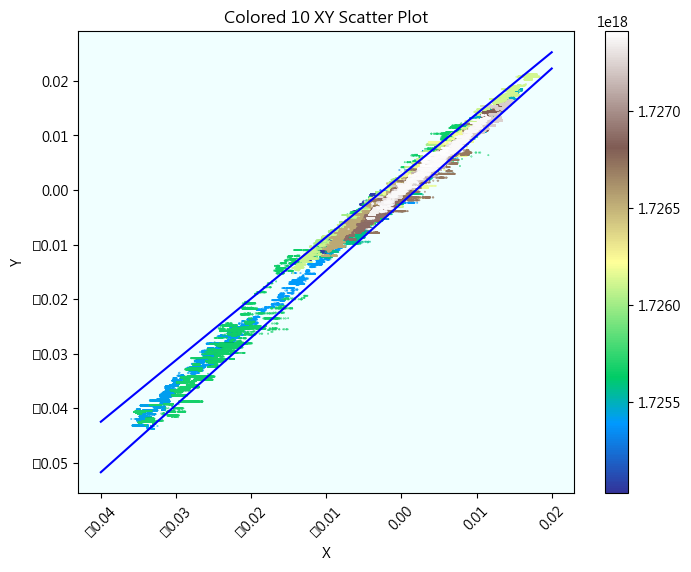

In [186]:
# 繪製散點圖
plt.figure(figsize=(8, 6))
plt.scatter(
    TXF_ZEF自減價格關係_df["price_percent_x"],
    TXF_ZEF自減價格關係_df["price_percent_y"],
    c=TXF_ZEF自減價格關係_df.ts,
    cmap="terrain",  # "Wistia",  # "CMRmap",  # "Greys",
    s=0.1,
)

# 設定x軸為日期格式
ax = plt.gca()
ax.set_facecolor("azure")
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# 加入前一個月的上下回歸線來比較一下
# 定義 x 的範圍
x_line = np.linspace(-0.04, 0.02, 100)  # 可根據需要調整範圍
plt.plot(x_line, 1.12854 * x_line + 0.00268, "b-", label="上邊界")
plt.plot(x_line, 1.23307 * x_line + (-0.00239), "b-", label="下邊界")


# 添加標題和軸標籤
plt.title("Colored 10 XY Scatter Plot")
plt.xlabel("X")
plt.ylabel("Y")
# 顯示圖形
plt.colorbar()
plt.show()

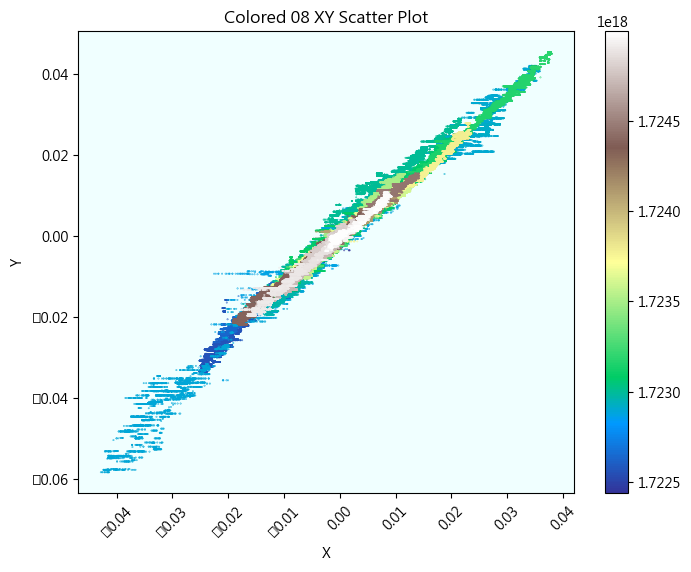
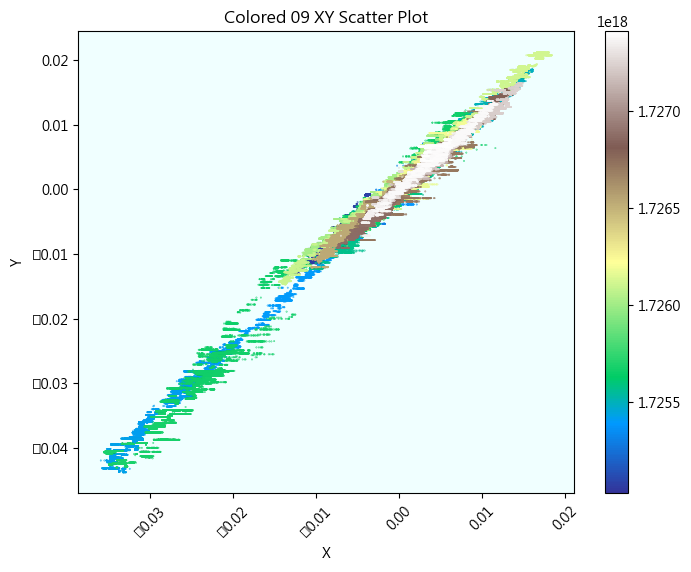
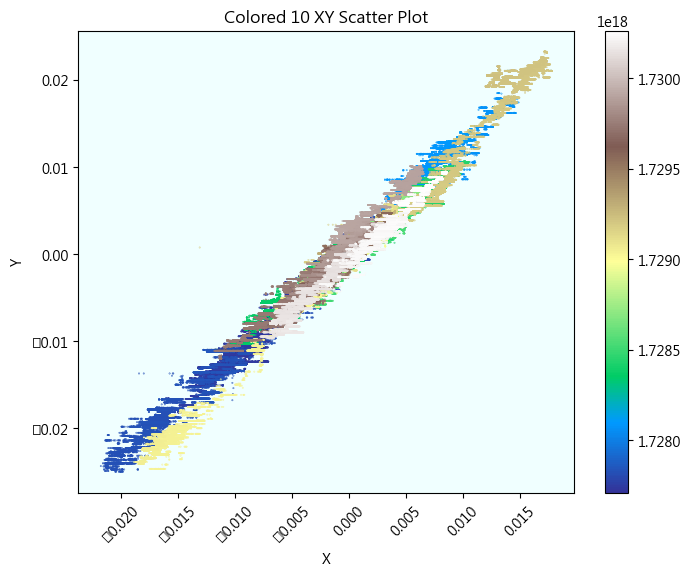

##### 計算回歸線

In [4]:
df_皮爾森 = TXF_ZEF自減價格關係_df.dropna()
# df_皮爾森減肥 = TXF_ZEF自減價格關係_df.dropna().head(10000)

d:\source\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


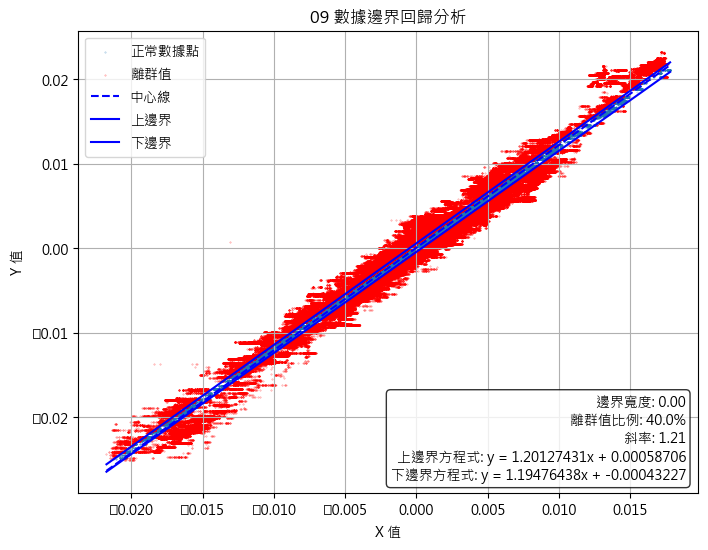

邊界寬度: 0.00
離群值比例: 40.0%
中心線斜率: 1.21
上邊界斜率: 1.20
下邊界斜率: 1.19
上邊界方程式: y = 1.20127431x + 0.00058706
下邊界方程式: y = 1.19476438x + -0.00043227


In [47]:
class BoundaryRegressor:
    def __init__(self, lower_quantile, upper_quantile):
        """
        初始化邊界回歸分析器

        參數:
        lower_quantile: 下邊界分位數 (0-1之間)
        upper_quantile: 上邊界分位數 (0-1之間)
        """
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, x, y):
        """
        擬合數據邊界
        """
        # 將數據整理為DataFrame格式
        df = pd.DataFrame({"x": x, "y": y})

        # 計算中心回歸線
        X = x.values.reshape(-1, 1)
        self.center_reg = LinearRegression()
        self.center_reg.fit(X, y)

        # 使用分位數回歸計算上下邊界
        model = QuantReg(y, sm.add_constant(x))
        self.lower_reg = model.fit(q=self.lower_quantile)
        self.upper_reg = model.fit(q=self.upper_quantile)

        # 計算邊界線間距
        self.boundary_width = (
            self.upper_reg.params[1] * np.mean(x) + self.upper_reg.params[0]
        ) - (self.lower_reg.params[1] * np.mean(x) + self.lower_reg.params[0])

        # 計算離邊界的距離
        y_upper = self.upper_reg.params[0] + self.upper_reg.params[1] * x
        y_lower = self.lower_reg.params[0] + self.lower_reg.params[1] * x

        # 計算點到邊界的距離
        distances_upper = y_upper - y
        distances_lower = y - y_lower

        # 標記離群值
        self.outliers = (distances_upper < 0) | (distances_lower < 0)

        return self

    def plot(self, x, y, figsize=(8, 6)):
        """
        繪製結果
        """
        plt.figure(figsize=figsize)

        # 繪製散點
        plt.scatter(
            x[~self.outliers], y[~self.outliers], alpha=0.5, label="正常數據點", s=0.1
        )
        plt.scatter(
            x[self.outliers],
            y[self.outliers],
            color="red",
            alpha=0.5,
            label="離群值",
            s=0.1,
        )

        # 生成預測線的x值
        x_line = np.array([x.min(), x.max()])

        # 繪製中心線
        y_center = self.center_reg.predict(x_line.reshape(-1, 1))
        plt.plot(x_line, y_center, "b--", label="中心線")

        # 繪製上下邊界線
        y_upper = self.upper_reg.params[0] + self.upper_reg.params[1] * x_line
        y_lower = self.lower_reg.params[0] + self.lower_reg.params[1] * x_line

        plt.plot(x_line, y_upper, "b-", label="上邊界")
        plt.plot(x_line, y_lower, "b-", label="下邊界")
        # 計算上邊界線的斜率和截距
        slope_upper = (y_upper[1] - y_upper[0]) / (x_line[1] - x_line[0])
        self.intercept_upper = y_upper[0] - slope_upper * x_line[0]

        # 計算下邊界線的斜率和截距
        slope_lower = (y_lower[1] - y_lower[0]) / (x_line[1] - x_line[0])
        self.intercept_lower = y_lower[0] - slope_lower * x_line[0]

        # 添加註解
        info_text = (
            f"邊界寬度: {self.boundary_width:.2f}\n"
            f"離群值比例: {self.outliers.mean():.1%}\n"
            f"斜率: {self.center_reg.coef_[0]:.2f}\n"
            f"上邊界方程式: y = {self.upper_reg.params[1]:.8f}x + {self.intercept_upper:.8f}\n"
            f"下邊界方程式: y = {self.lower_reg.params[1]:.8f}x + {self.intercept_lower:.8f}"
        )
        plt.text(
            0.98,  # 改為0.98,靠右側
            0.02,  # 改為0.02,靠下方
            info_text,
            transform=plt.gca().transAxes,
            horizontalalignment="right",  # 改為靠右對齊
            verticalalignment="bottom",   # 改為靠下對齊
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        plt.xlabel("X 值")
        plt.ylabel("Y 值")
        plt.title("09 數據邊界回歸分析")
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_statistics(self):
        """
        獲取統計信息
        """
        return {
            "boundary_width": self.boundary_width,
            "outlier_ratio": self.outliers.mean(),
            "center_slope": self.center_reg.coef_[0],
            "upper_slope": self.upper_reg.params[1],
            "lower_slope": self.lower_reg.params[1],
            "outlier_indices": np.where(self.outliers)[0],
            "upper_intercept": self.intercept_upper,
            "lower_intercept": self.intercept_lower,
            "upper_equation": f"y = {self.upper_reg.params[1]:.8f}x + {self.intercept_upper:.8f}",
            "lower_equation": f"y = {self.lower_reg.params[1]:.8f}x + { self.intercept_lower:.8f}",
        }

plt.style.use("default")
# 創建分析器實例
regressor = BoundaryRegressor(lower_quantile=0.2, upper_quantile=0.8)

# 擬合數據
x = df_皮爾森["price_percent_x"]
y = df_皮爾森["price_percent_y"]
regressor.fit(x, y)

# 繪製結果
regressor.plot(x, y)

# 獲取統計信息
stats = regressor.get_statistics()
print(f"邊界寬度: {stats['boundary_width']:.2f}")
print(f"離群值比例: {stats['outlier_ratio']:.1%}")
print(f"中心線斜率: {stats['center_slope']:.2f}")
print(f"上邊界斜率: {stats['upper_slope']:.2f}")
print(f"下邊界斜率: {stats['lower_slope']:.2f}")
print(f"上邊界方程式: {stats['upper_equation']}")
print(f"下邊界方程式: {stats['lower_equation']}")

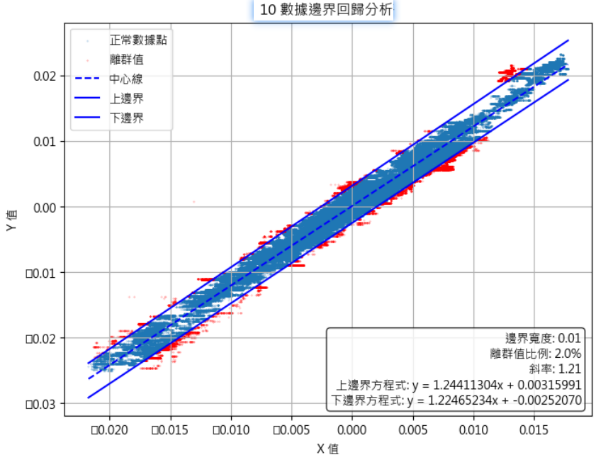
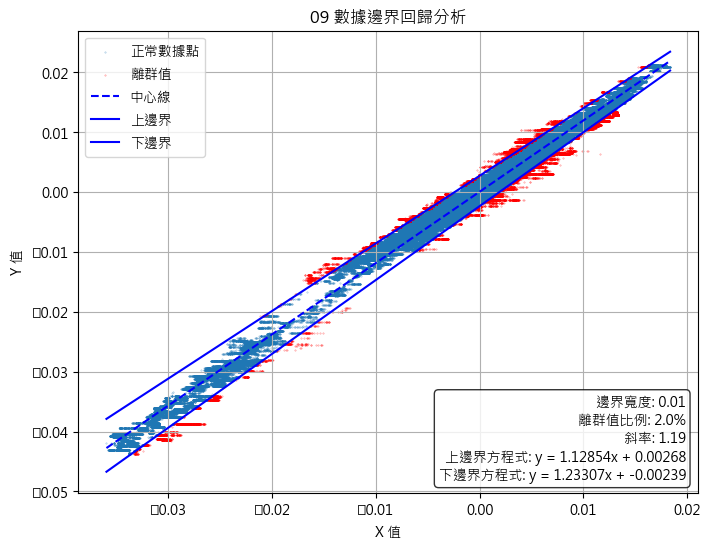
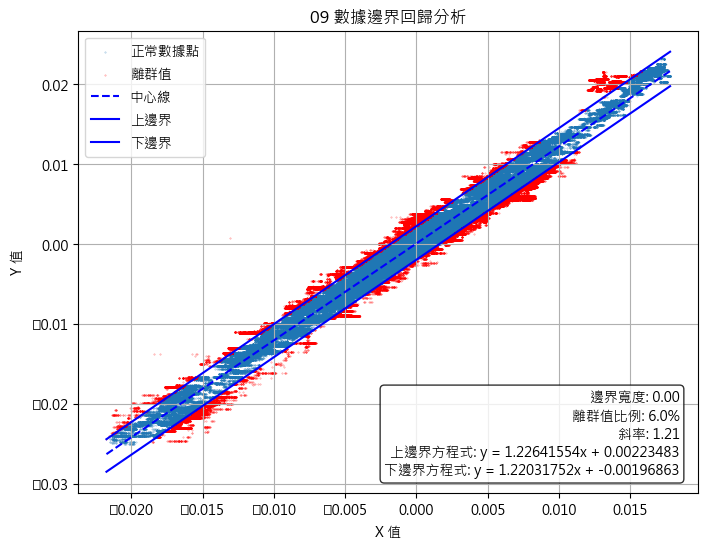
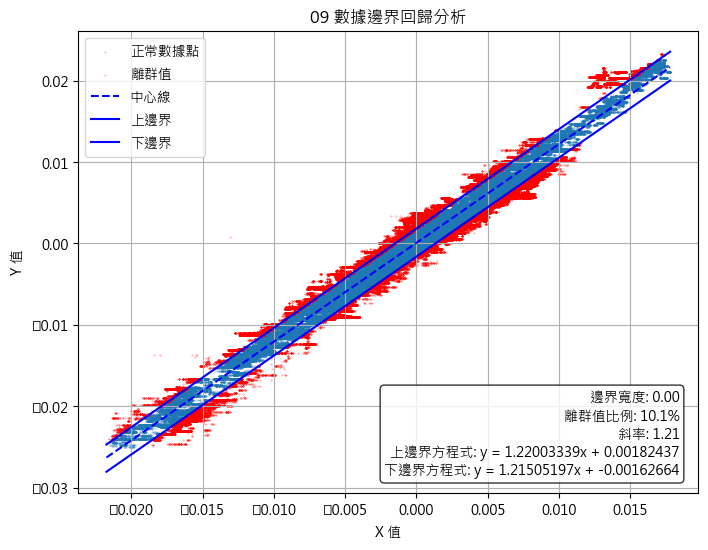
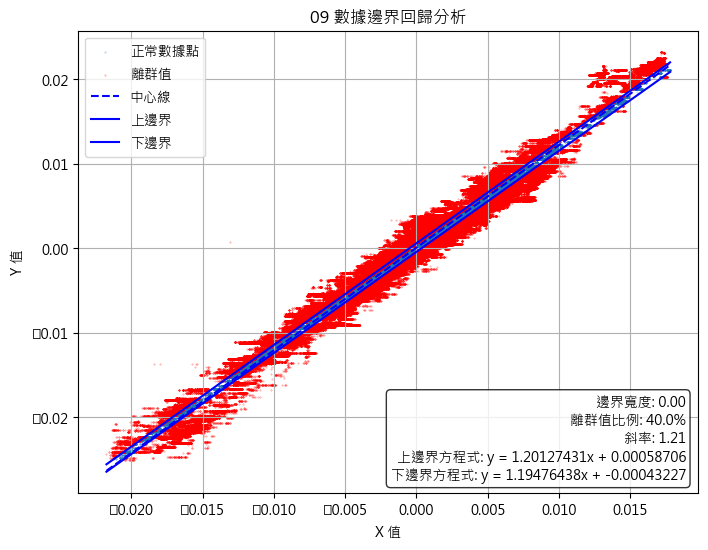
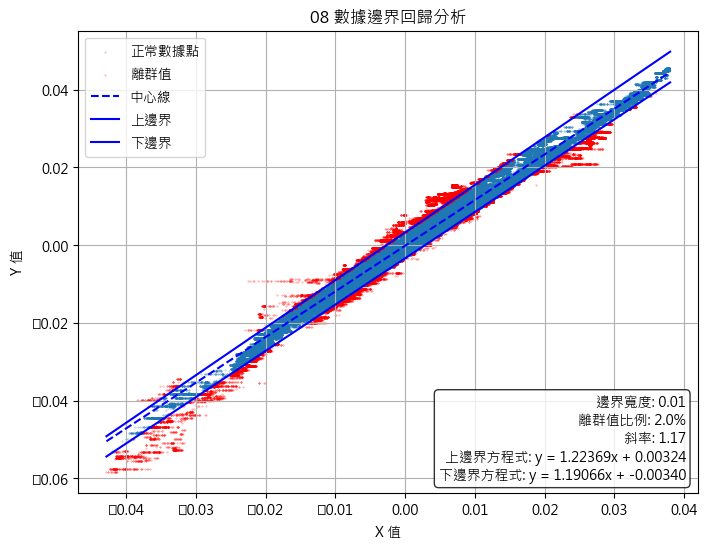
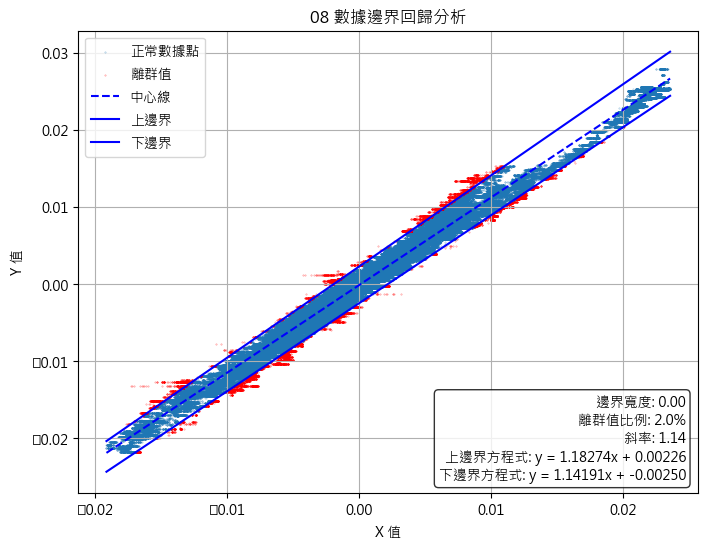

##### 開始回測

In [48]:
txf_df = TXF10_df_sec_close.copy()
zef_df = ZEF10_df_sec_close.copy()
def calculate_price_difference_vectorized(df_other, df_origin):
    # 處理 XIF 數據
    df_other["datetime"] = pd.to_datetime(df_other["ts"])
    df_other["date"] = df_other["datetime"].dt.date
    df_other["hour"] = df_other["datetime"].dt.hour
    daily_last_close = (
        df_other[df_other["hour"].isin([15])].groupby("date")["close"].last()
    )

    # 處理 TXF 數據
    df_origin["datetime"] = pd.to_datetime(df_origin["ts"])
    df_origin["date"] = df_origin["datetime"].dt.date
    df_origin["hour"] = df_origin["datetime"].dt.hour

    # 創建條件遮罩
    after_15 = df_origin["hour"] >= 15
    before_5 = df_origin["hour"] < 5

    # 為凌晨交易創建前一天的日期
    df_origin["ref_date"] = df_origin["date"]
    df_origin.loc[before_5, "ref_date"] = (
        df_origin.loc[before_5, "datetime"] - pd.Timedelta(days=1)
    ).dt.date

    # 使用map函數批量查找對應的收盤價
    df_origin["xif_close"] = df_origin["ref_date"].map(daily_last_close)

    # 計算價差
    # 只在交易時間內（15:00後或5:00前）計算價差
    df_origin["price_diff"] = np.where(
        (after_15 | before_5), df_origin["close"] - df_origin["xif_close"], np.nan
    )
    df_origin["price_percent"] = df_origin["price_diff"] / df_origin["close"]
    # 清理臨時列
    df_origin.drop(["datetime", "hour", "ref_date", "xif_close"], axis=1, inplace=True)

    return df_origin


# 執行計算
# txf_df = calculate_price_difference_vectorized(xif_df, txf_df)
txf_df = calculate_price_difference_vectorized(txf_df, txf_df)
zef_df = calculate_price_difference_vectorized(zef_df, zef_df)

TXF_ZEF自減價格關係_df = pd.merge(
    txf_df[["ts", "price_percent","close"]],
    zef_df[["price_percent","close"]],
    how="inner",
    left_index=True,
    right_index=True,
).dropna()
TXF_ZEF自減價格關係_df

,ts,price_percent_x,close_x,price_percent_y,close_y
0,2024-09-30 15:00:01,-0.002463,22327.0,-0.001052,1188.60
1,2024-09-30 15:00:02,-0.001746,22343.0,-0.002823,1186.50
2,2024-09-30 15:00:03,-0.001566,22347.0,-0.002823,1186.50
3,2024-09-30 15:00:04,-0.001566,22347.0,-0.002823,1186.50
4,2024-09-30 15:00:05,-0.001477,22349.0,-0.002823,1186.50
...,...,...,...,...,...
2555921,2024-10-30 04:58:42,0.005075,23055.0,0.005589,1261.40
2555922,2024-10-30 04:58:43,0.005075,23055.0,0.005589,1261.40
2555923,2024-10-30 04:58:44,0.005075,23055.0,0.005589,1261.40
2555924,2024-10-30 04:58:45,0.005075,23055.0,0.005589,1261.40


In [96]:
TXF_ZEF自減價格關係_df.to_csv("datas/觀察TXF_ZEF自減價格關係.csv")

In [ ]:
def generate_signal(df,上A,上B,下A,下B):
    """
    根據給定的條件生成信號欄位：
    - 當 percent_y > 1.2237 * percent_x + 0.00324 時，signal = 1
    - 當 percent_y > 1.119066 * percent_x - 0.00340 時，signal = -1
    - 其餘情況，signal = 0

    Parameters:
    df (pandas.DataFrame): 包含 percent_x 和 percent_y 欄位的 DataFrame

    Returns:
    pandas.DataFrame: 添加 signal 欄位後的 DataFrame
    """
    # 創建一個新的 DataFrame 副本
    result_df = df.copy()

    # 初始化 signal 欄位為 0
    result_df["signal"] = 0

    # 條件 1: 當 percent_y > 1.2237 * percent_x + 0.00324 時，signal = 1
    condition1 = df["price_percent_y"] > (上A * df["price_percent_x"] + 上B)
    result_df.loc[condition1, "signal"] = 1
    up_price = 上A * df["price_percent_x"] + 上B
    result_df.loc[condition1, "up_price"] = up_price

    # 條件 2: 當 percent_y > 1.119066 * percent_x - 0.00340 時，signal = -1
    condition2 = df["price_percent_y"] < (下A * df["price_percent_x"] - 下B)
    result_df.loc[condition2, "signal"] = -1
    down_price = 下A * df["price_percent_x"] - 下B
    result_df.loc[condition2, "down_price"] = down_price
    return result_df


# 使用範例：
# 交易訊號09_df = generate_signal(
#     TXF_ZEF自減價格關係_df, 上A=1.2237, 上B=0.00324, 下A=1.119066, 下B=0.00340
# )  # 含有8/5
# 交易訊號09_df = generate_signal(
#     TXF_ZEF自減價格關係_df, 上A=1.24411304, 上B=0.00315991, 下A=1.22465234, 下B=0.00252
# )
# 交易訊號10_df = generate_signal(
#     TXF_ZEF自減價格關係_df, 上A=1.12854, 上B=0.00268, 下A=1.23307, 下B=0.00239
# ) #2%
# 交易訊號10_df = generate_signal(
#     TXF_ZEF自減價格關係_df, 上A=1.24411304, 上B=0.0031599, 下A=1.22624902, 下B=0.00287
# ) #1%不佳
# 交易訊號10_df = generate_signal(
#     TXF_ZEF自減價格關係_df, 上A=1.22641554, 上B=0.00223483, 下A=1.22031752, 下B=0.00196863
# )  # 3% 居然更好
# 交易訊號10_df = generate_signal(
#     TXF_ZEF自減價格關係_df, 上A=1.22003339, 上B=0.00182437, 下A=1.21505197, 下B=0.00162664
# )  # 5%
交易訊號10_df = generate_signal(
    TXF_ZEF自減價格關係_df, 上A=1.20127431, 上B=0.00058706, 下A=1.19476438, 下B=0.00043227
)  # 20% 有比5%還要少了
交易訊號10_df

,ts,price_percent_x,close_x,price_percent_y,close_y,signal,up_price,down_price
0,2024-09-30 15:00:01,-0.002463,22327.0,-0.001052,1188.60,1,-0.002372,NaN
1,2024-09-30 15:00:02,-0.001746,22343.0,-0.002823,1186.50,-1,NaN,-0.002518
2,2024-09-30 15:00:03,-0.001566,22347.0,-0.002823,1186.50,-1,NaN,-0.002304
3,2024-09-30 15:00:04,-0.001566,22347.0,-0.002823,1186.50,-1,NaN,-0.002304
4,2024-09-30 15:00:05,-0.001477,22349.0,-0.002823,1186.50,-1,NaN,-0.002196
...,...,...,...,...,...,...,...,...
2555921,2024-10-30 04:58:42,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631
2555922,2024-10-30 04:58:43,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631
2555923,2024-10-30 04:58:44,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631
2555924,2024-10-30 04:58:45,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631


In [ ]:
交易訊號10_df

##### 這個版本超慢

In [ ]:
def optimized_backtest(df):
    """
    使用向量化操作執行策略回測

    Parameters:
    df (pandas.DataFrame): 包含必要欄位的 DataFrame

    Returns:
    pandas.DataFrame: 添加 position 和 pnl 欄位後的 DataFrame
    """
    # 創建副本避免修改原始數據
    result_df = df.copy()

    # 將時間轉換為 datetime 並提取小時
    result_df["ts"] = pd.to_datetime(result_df.index)
    result_df["hour"] = result_df["ts"].dt.hour

    # 初始化欄位
    result_df["position"] = 0
    result_df["entry_price"] = 0.0
    result_df["pnl"] = 0.0

    # 創建遮罩標記可能的開倉點
    valid_hours = result_df["hour"] != 4  # 排除4-5點

    # 找出所有潛在的開倉點
    long_entries = (result_df["signal"] == -1) & valid_hours
    short_entries = (result_df["signal"] == 1) & valid_hours

    # 使用 numpy 來加速計算
    positions = np.zeros(len(result_df))
    entry_prices = np.zeros(len(result_df))
    pnl = np.zeros(len(result_df))

    # 初始化變數
    current_position = 0
    entry_price = 0
    cumulative_pnl = 0
    last_loss_hour = -1

    # 使用 numpy 的 where 函數來找出所有交易點
    entry_points = np.where(long_entries | short_entries)[0]

    for i in range(len(result_df)):
        hour = result_df.iloc[i]["hour"]
        price = result_df.iloc[i]["close_y"]

        # 如果有持倉
        if current_position != 0:
            unrealized_pnl = (price - entry_price) * current_position

            # 檢查是否需要平倉
            need_exit = False

            # 強制平倉時間
            if hour == 4:
                need_exit = True
            # 停損停利
            elif abs(unrealized_pnl) >= 2:
                need_exit = True
                if unrealized_pnl < 0:
                    last_loss_hour = hour

            if need_exit:
                cumulative_pnl += unrealized_pnl
                current_position = 0
                entry_price = 0

        # 如果沒有持倉且在可交易時間
        elif hour != 4 and hour != last_loss_hour:
            # 檢查是否有開倉信號
            if long_entries[i]:
                current_position = 1
                entry_price = price
            elif short_entries[i]:
                current_position = -1
                entry_price = price

        # 更新陣列
        positions[i] = current_position
        entry_prices[i] = entry_price
        pnl[i] = cumulative_pnl

    # 將計算結果寫回 DataFrame
    result_df["position"] = positions
    result_df["entry_price"] = entry_prices
    result_df["pnl"] = pnl

    # 移除輔助欄位
    result_df = result_df.drop(["ts", "hour"], axis=1)

    return result_df


# 使用範例：
回測結果10_df = optimized_backtest(交易訊號09_df)

numba加速

##### 回測1

In [ ]:
@jit(nopython=True)
def compute_positions_and_pnl(signals, hours, prices, n_rows):
    """
    使用 numba 加速核心計算邏輯
    """
    positions = np.zeros(n_rows)
    pnl = np.zeros(n_rows)
    entry_prices = np.zeros(n_rows)

    current_position = 0
    entry_price = 0.0
    cumulative_pnl = 0.0
    last_loss_hour = -1

    for i in range(n_rows):
        hour = hours[i]
        price = prices[i]

        # 如果有持倉
        if current_position != 0:
            unrealized_pnl = (price - entry_price) * current_position

            # 檢查是否需要平倉 (合併條件檢查)
            if hour == 4 or abs(unrealized_pnl) >= 1:
                cumulative_pnl += unrealized_pnl
                if unrealized_pnl < 0:
                    last_loss_hour = hour
                current_position = 0
                entry_price = 0

        # 如果沒有持倉且可以開倉
        elif hour != 4 and hour != last_loss_hour:
            last_loss_hour=-1
            signal = signals[i]
            if signal == -1:
                current_position = 1
                entry_price = price
            elif signal == 1:
                current_position = -1
                entry_price = price

        positions[i] = current_position
        entry_prices[i] = entry_price
        pnl[i] = cumulative_pnl

    return positions, pnl, entry_prices


def ultra_fast_backtest(df):
    """
    使用 numba 和向量化操作的超快回測函數

    Parameters:
    df (pandas.DataFrame): 包含必要欄位的 DataFrame

    Returns:
    pandas.DataFrame: 添加 position 和 pnl 欄位後的 DataFrame
    """
    # 創建副本避免修改原始數據
    result_df = df.copy()

    # 將時間轉換為小時 (向量化操作)
    hours = pd.to_datetime(result_df.index).hour.values

    # 準備 numba 需要的數組
    signals = result_df["signal"].values
    prices = result_df["close_y"].values
    n_rows = len(result_df)

    # 使用 numba 加速的核心計算
    positions, pnl, entry_prices = compute_positions_and_pnl(
        signals, hours, prices, n_rows
    )

    # 將結果寫回 DataFrame
    result_df["position"] = positions
    result_df["pnl"] = pnl
    result_df["entry_price"] = entry_prices

    return result_df


# 使用範例：
回測結果10_df = ultra_fast_backtest(交易訊號10_df)


# 效能測試程式碼
def test_performance(df):
    import time

    # 測試原始版本
    start_time = time.time()
    result1 = backtest_strategy(df)
    original_time = time.time() - start_time
    print(f"Original version time: {original_time:.4f} seconds")

    # 測試優化版本 1
    start_time = time.time()
    result2 = optimized_backtest(df)
    optimized_time = time.time() - start_time
    print(f"Optimized version time: {optimized_time:.4f} seconds")

    # 測試 numba 優化版本
    # 預熱 JIT 編譯
    _ = ultra_fast_backtest(df.iloc[:100])

    start_time = time.time()
    result3 = ultra_fast_backtest(df)
    ultra_time = time.time() - start_time
    print(f"Ultra fast version time: {ultra_time:.4f} seconds")

    # 驗證結果
    print("\nResults verification:")
    print("Original vs Optimized match:", (result1["pnl"] == result2["pnl"]).all())
    print("Original vs Ultra fast match:", (result1["pnl"] == result3["pnl"]).all())

    # 效能提升
    print(f"\nOptimized version speedup: {original_time/optimized_time:.1f}x")
    print(f"Ultra fast version speedup: {original_time/ultra_time:.1f}x")

    return result1, result2, result3

In [95]:
signals = 交易訊號10_df["signal"].values
signals

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
回測結果10_df

,ts,price_percent_x,close_x,price_percent_y,close_y,signal,position,pnl,entry_price
0,2024-08-30 15:00:01,-0.002688,22325.0,-0.004662,1190.45,0,0.0,0.0,0.0
1,2024-08-30 15:00:02,-0.003137,22315.0,-0.004662,1190.45,0,0.0,0.0,0.0
2,2024-08-30 15:00:03,-0.003137,22315.0,-0.004662,1190.45,0,0.0,0.0,0.0
3,2024-08-30 15:00:04,-0.003137,22315.0,-0.004662,1190.45,0,0.0,0.0,0.0
4,2024-08-30 15:00:05,-0.002822,22322.0,-0.004662,1190.45,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2383194,2024-09-27 04:59:55,0.003964,23210.0,0.004433,1252.05,0,0.0,1.6,0.0
2383195,2024-09-27 04:59:56,0.003964,23210.0,0.004433,1252.05,0,0.0,1.6,0.0
2383196,2024-09-27 04:59:57,0.003642,23202.5,0.004433,1252.05,0,0.0,1.6,0.0
2383197,2024-09-27 04:59:58,0.003620,23202.0,0.004433,1252.05,0,0.0,1.6,0.0


In [ ]:
回測結果10_df.to_csv("datas/觀察回測結果09_df.csv")

##### 回測2

In [60]:
@jit(nopython=True)
def compute_positions_and_pnl(signals, hours, prices, n_rows):
    """
    使用 numba 加速核心計算邏輯，新增 floating_pnl 欄位並修改避開入場的條件
    """
    positions = np.zeros(n_rows)
    pnl = np.zeros(n_rows)
    floating_pnl = np.zeros(n_rows)
    entry_prices = np.zeros(n_rows)

    current_position = 0
    entry_price = 0.0
    cumulative_pnl = 0.0
    last_loss_row = -301  # 初始化為超過 300 個 row 之前的值，以便一開始可以正常入場

    for i in range(n_rows):
        price = prices[i]

        # 如果有持倉，計算浮動盈虧
        if current_position != 0:
            unrealized_pnl = (price - entry_price) * current_position
            floating_pnl[i] = unrealized_pnl

            # 檢查是否需要平倉 (合併條件檢查)
            if (
                hours[i] == 4
                or hours[i] == 5
                or unrealized_pnl > 1
                or unrealized_pnl < -1
            ):
                cumulative_pnl += unrealized_pnl
                if unrealized_pnl < 0:
                    last_loss_row = i  # 記錄虧損發生的 row
                current_position = 0
                entry_price = 0
                floating_pnl[i] = 0  # 平倉後浮動盈虧歸零

        # 如果沒有持倉且可以開倉
        elif i > last_loss_row + 300:  # 避開上次虧損發生後 300 個 row
            signal = signals[i]
            if signal == -1:
                current_position = 1
                entry_price = price
            elif signal == 1:
                current_position = -1
                entry_price = price

        # 儲存目前的持倉資訊
        positions[i] = current_position
        entry_prices[i] = entry_price
        pnl[i] = cumulative_pnl

    return positions, pnl, entry_prices, floating_pnl


def ultra_fast_backtest(df):
    """
    使用 numba 和向量化操作的超快回測函數
    """
    # 創建副本避免修改原始數據
    result_df = df.copy()

    # 將時間轉換為小時 (向量化操作)
    hours = pd.to_datetime(result_df.ts).dt.hour.values

    # 準備 numba 需要的數組
    signals = result_df["signal"].values
    prices = result_df["close_y"].values
    n_rows = len(result_df)

    # 使用 numba 加速的核心計算
    positions, pnl, entry_prices, floating_pnl = compute_positions_and_pnl(
        signals, hours, prices, n_rows
    )

    # 將結果寫回 DataFrame
    result_df["position"] = positions
    result_df["pnl"] = pnl
    result_df["entry_price"] = entry_prices
    result_df["floating_pnl"] = floating_pnl
    result_df["hours"] = hours

    return result_df

回測結果_df = ultra_fast_backtest(交易訊號10_df)
回測結果_df.tail()

,ts,price_percent_x,close_x,price_percent_y,close_y,signal,up_price,down_price,position,pnl,entry_price,floating_pnl,hours
2555921,2024-10-30 04:58:42,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631,1.0,195.1725,1261.4,0.0,4
2555922,2024-10-30 04:58:43,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631,0.0,195.1725,0.0,0.0,4
2555923,2024-10-30 04:58:44,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631,1.0,195.1725,1261.4,0.0,4
2555924,2024-10-30 04:58:45,0.005075,23055.0,0.005589,1261.40,-1,NaN,0.005631,0.0,195.1725,0.0,0.0,4
2555925,2024-10-30 04:58:46,0.005075,23055.0,0.006337,1262.35,0,NaN,NaN,0.0,195.1725,0.0,0.0,4


In [61]:
回測結果_df.to_csv("datas/觀察回測結果10_df.csv")

C:\Users\tseng\AppData\Local\Temp\ipykernel_24844\3580804271.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


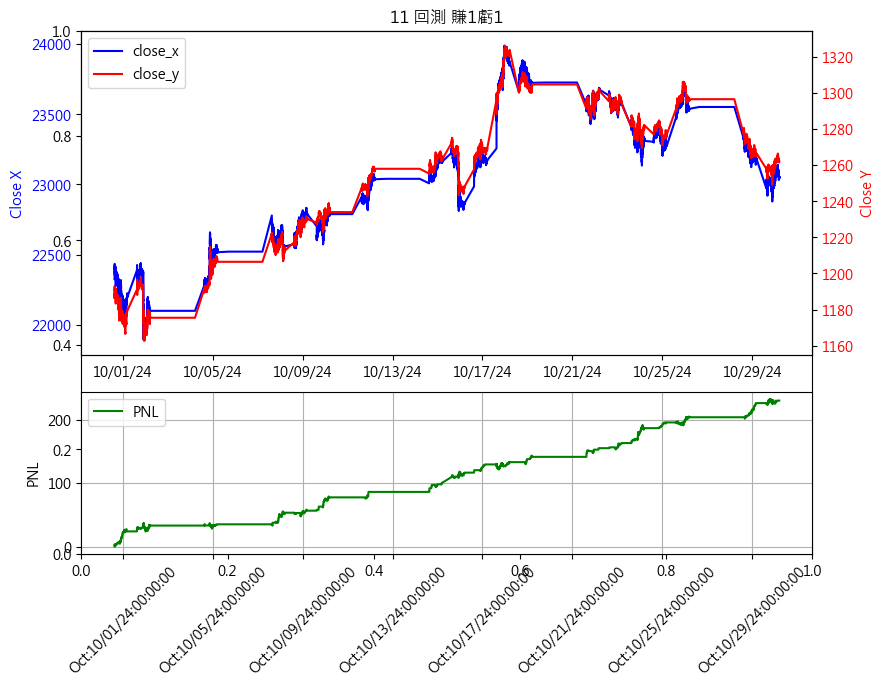

In [45]:
%matplotlib inline
df = 回測結果_df.copy()

# 假設您的數據已經在 df DataFrame 中
# 設置圖表風格
plt.style.use("default")

# 創建圖表和軸域
fig = plt.figure(figsize=(8, 6))
plt.title("11 回測 賺1虧1")

# 創建上下兩個子圖，height_ratios=[2, 1] 表示上圖高度是下圖的2倍
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.15)
ax1 = fig.add_subplot(gs[0])
ax2 = ax1.twinx()  # 創建雙Y軸
ax3 = fig.add_subplot(gs[1])

# 繪製 close_x 在左Y軸
line1 = ax1.plot(df["ts"], df["close_x"], color="blue", label="close_x")
ax1.set_ylabel("Close X", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 繪製 close_y 在右Y軸
line2 = ax2.plot(df["ts"], df["close_y"], color="red", label="close_y")
ax2.set_ylabel("Close Y", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# 添加圖例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

# 繪製下方的 PNL 圖
ax3.plot(df["ts"], df["pnl"], color="green", label="PNL")
ax3.set_ylabel("PNL")
ax3.legend(loc="upper left")

# 設置 x 軸格式
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

for ax in [ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b:%D:%H:%M:%S"))
    plt.xticks(rotation=45)
    ax.grid(True)

# 只在底部子圖顯示 x 軸標籤
# ax1.set_xticklabels([])

# 調整布局
plt.tight_layout()
# 顯示圖表
plt.show()

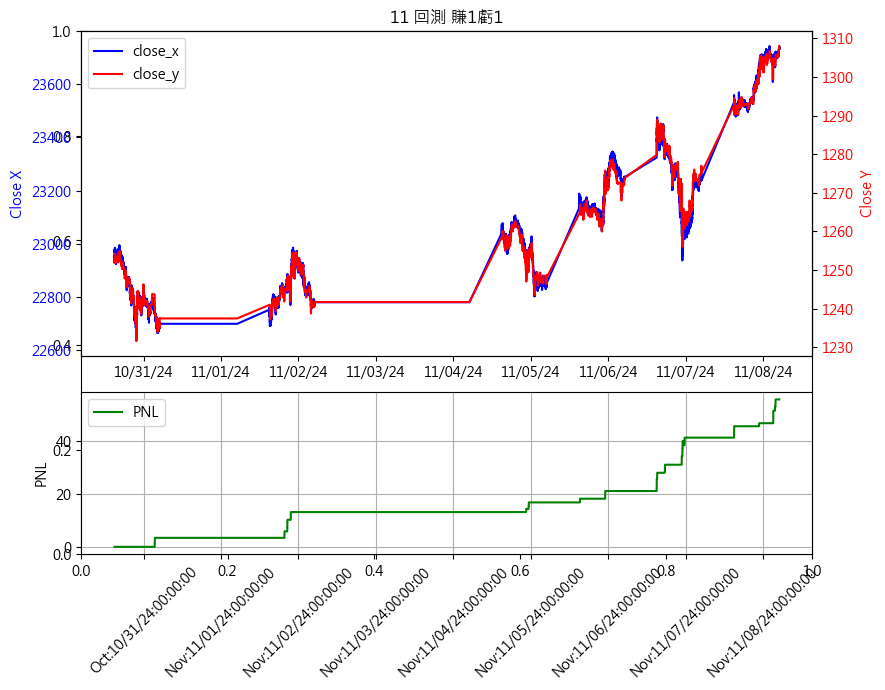
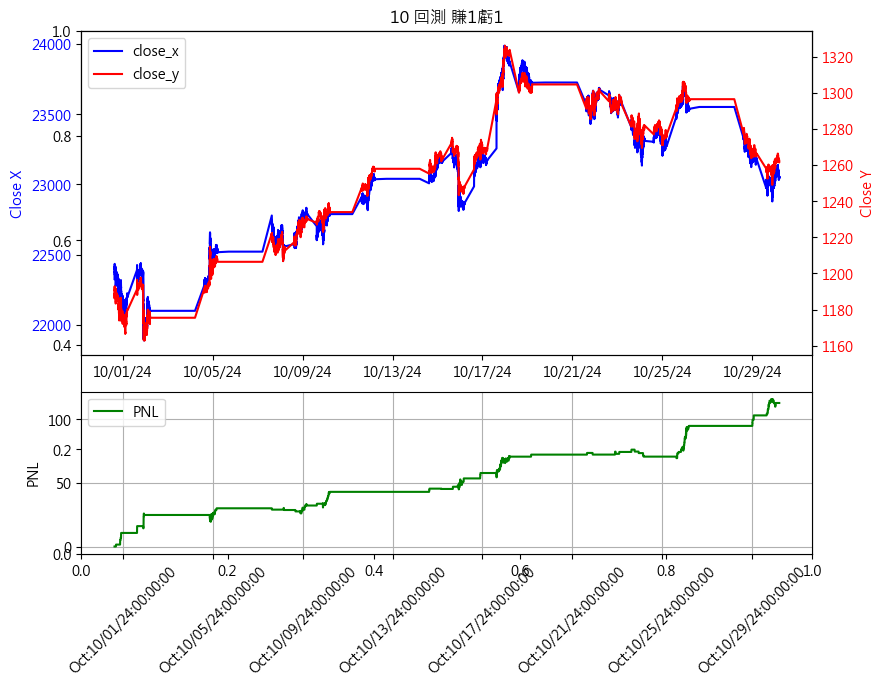
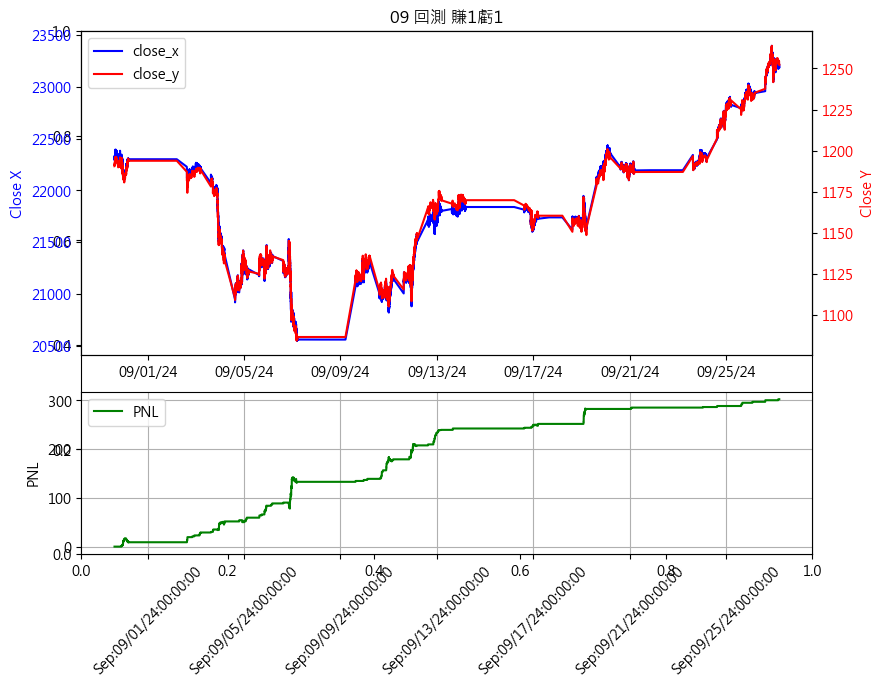